In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
%autosave 20

Autosaving every 20 seconds


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms

In [3]:
from torchsummary import summary

In [4]:
from tqdm import tqdm
import numpy as np
import sys
import gc
import os
import matplotlib.pyplot as plt
from rf_calc import receptive_field

In [5]:
f'Torch CUDA Version :{torch.version.cuda}'
f'Torch Version :{torch.__version__}'
f'Numpy Version :{np.__version__}'
f'Python Version :{sys.version}'

'Torch CUDA Version :11.6'

'Torch Version :1.13.0'

'Numpy Version :1.23.5'

'Python Version :3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]'

###  GPU check

In [6]:
#Gpu Cleaner
def clean_gpu():
    """Considering we have GPUs"""

    gc.collect()
    torch.cuda.empty_cache()
    return None

#Gpu Info Check
def gpu_info():
    gpu_info = os.popen("nvidia-smi").read()
    # gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

In [7]:
def gpu_check(seed_val = 1):
    print('The Seed is set to {}'.format(seed_val))
    if torch.cuda.is_available():
        print('Model will Run on CUDA.')
        torch.cuda.manual_seed(seed_val)
        device = 'cuda'
    else:
        torch.manual_seed(seed_val)
        print ('Running in CPU')
        device = 'cpu'
    cuda = torch.cuda.is_available()
    return cuda,seed_val,device

In [8]:
gpu_info()
clean_gpu()

Tue Jan  3 21:33:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P5    20W /  N/A |     74MiB / 16384MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
cuda,SEED,device = gpu_check(seed_val=1)

The Seed is set to 1
Model will Run on CUDA.


In [10]:
# Train transformations
train_transforms = transforms.Compose([ transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test transformations
test_transforms = transforms.Compose([ transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                     ])

### Downloading the MNIST dataset with the Transforms created

In [11]:
train_d = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_d = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

### Data generator for Mnist and Randomnumber  

In [12]:
def data_generator(typ ,MNIST,N):
    X = torch.randint(low=0, high=10, size=(N,))
    
    if typ == 'train':
        image = train_d.train_data
        labels = train_d.train_labels
    elif typ == 'test':
        image = test_d.test_data
        labels = test_d.test_labels
    else:
        print ('Input the Type')
    return image,labels,X,X+labels

###  Creating Dataloader Classfor custom dataset

In [13]:
class MNISTRandom_loader(Dataset,):
    def __init__(self,Image,Image_lables, X,transform=None):
        self.image = Image.float()
        self.image_labels = Image_lables
        self.Y = X + self.image_labels
        self.Y = F.one_hot(self.Y,num_classes =19 )
        self.X = F.one_hot(X,num_classes = 10)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):

        if self.transform:
            self.image = self.transform(self.image)
        return self.image[idx,:].reshape(1,28,28), self.image_labels[idx], self.X[idx,:], self.Y[idx,:]

In [14]:
train_images,train_labels,train_random_num,train_labels2 = data_generator('train',train_d,train_d.train_labels.shape[0])
test_images,test_labels,test_random_num,test_labels2 = data_generator('test',test_d,test_d.test_labels.shape[0])

In [15]:
train_data = MNISTRandom_loader(train_images,train_labels,train_random_num)
test_data = MNISTRandom_loader(test_images,test_labels,test_random_num)

###  Trainning size and test size

In [16]:
train_data.image.shape

torch.Size([60000, 28, 28])

In [17]:
test_data.image.shape

torch.Size([10000, 28, 28])

### If GPU batch size =128 (I have GPU here ) else 64 

In [18]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

In [19]:
train_loader = DataLoader(train_data, **dataloader_args)
test_loader = DataLoader(test_data, **dataloader_args)

### Mnist Model (Model 1)

In [20]:
class MNISt(nn.Module):
    def __init__(self):
        super(MNISt, self).__init__()
        dropout_value = 0.01
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) 
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU(),
        ) 
        self.pool1 = nn.MaxPool2d(2, 2) 
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(11, 11), padding=0, bias=False),
        ) 


    def forward(self, x):
#         print (x.shape)
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x.view(-1, 10)
        out = F.log_softmax(x, dim=-1)
        return x,out
    
    def backward(self, retain_variables=True):
        #retain_variables True??
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [21]:
model1 = MNISt().to(device)

In [22]:
_ = receptive_field(model1,28)

=======================================Reciptive Field Calculator========================================
|    | Kernel_size   | Padding   |   Stride | Input_Img_size   | Output_Img_size   | Receptive_field   |
|---:|:--------------|:----------|---------:|:-----------------|:------------------|:------------------|
|  0 | 3*3           | NO        |        1 | 28*28            | 26*26             | 3*3               |
|  1 | 3*3           | NO        |        1 | 26*26            | 24*24             | 5*5               |
|  2 | 3*3           | NO        |        1 | 24*24            | 22*22             | 7*7               |
|  3 | 2*2           | NO        |        2 | 22*22            | 11*11             | 8*8               |
|  4 | 1*1           | NO        |        1 | 11*11            | 11*11             | 8*8               |


In [52]:
summary(model1,input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
      BatchNorm2d-10           [-1, 15, 22, 22]              30
             ReLU-11           [-1, 15, 22, 22]               0
        MaxPool2d-12           [-1, 15, 11, 11]               0
           Conv2d-13             [-1, 10, 1, 1]          18,150
Total params: 20,560
Trainable params: 

### Testing the Mnist model output size

In [23]:
d = torch.rand(1,1,28,28).cuda()

In [24]:
x,out  = model1(d)

In [25]:
out.shape

torch.Size([1, 10])

In [26]:
x.numel()

10

### Mnist + Random number addition model (Model2) 

In [27]:
class MNISTadder(nn.Module):
    def __init__(self):
        super(MNISTadder,self).__init__()
        dropout_value = 0.01
        self.mnist_mode = MNISt().to('cuda')  #Calling the Mnist model 
        
        self.layer1 = nn.Sequential(nn.Linear(in_features=20,out_features=32),
                            nn.BatchNorm1d(32),
                            nn.ReLU(),
                            nn.Dropout(dropout_value)
                                   )

        self.layer2 = nn.Sequential(nn.Linear(in_features=32,out_features=64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Dropout(dropout_value)
                                   )

        self.layer3 = nn.Sequential(nn.Linear(in_features=64,out_features=128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(dropout_value)
                                   )

        self.model2_out = nn.Linear(in_features=128,out_features=19)
        #         self.model1_out = nn.Linear(in_features=32,out_features=10)
        
    def forward(self,mnist_img,Num ):
        
        mnist_d,pred_image = self.mnist_mode(mnist_img)  # Mnist model o/p will be saved here
        mnist_number = torch.cat([mnist_d,Num],dim  = -1)  # concatenation of Mninst  out FC for summing
        
        x = self.layer1(mnist_number) #Trainning the Addition of Mnist and Ransom number 
        x = self.layer2(x)
        x = self.layer3(x)
        out2 = self.model2_out(x)
        return pred_image,out2

In [84]:
summary(model2, [(1,28,28),(10,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
      BatchNorm2d-10           [-1, 15, 22, 22]              30
             ReLU-11           [-1, 15, 22, 22]               0
        MaxPool2d-12           [-1, 15, 11, 11]               0
           Conv2d-13             [-1, 10, 1, 1]          18,150
            MNISt-14       [[-1, 10], [

TypeError: can't multiply sequence by non-int of type 'tuple'

In [28]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'Model can run on CUDA {device}')

model2 = MNISTadder().to(device)

Model can run on CUDA cuda


In [29]:
train_losses_image = []
train_losses_random = []

test_losses_image = []
test_losses_random = []

train_acc = []
test_acc = []

### Custom Accuracy Function

In [30]:
def accuracy(model, ds):
    # assumes model.eval()
    n_correct = 0; n_wrong = 0
    # using loader avoids resize() issues
    ldr = DataLoader(ds, batch_size=1,shuffle=False)
    for _, (data1,target1,data2,target2) in enumerate(ldr):
        data,target = data.to('cuda'),target.to('cuda')
        X = data
        Y = target
        with torch.no_grad():
            y_pred1,y_pred2 = model(data1,data2)  # probs form    
        if torch.argmax(Y) == torch.argmax(oupt):
            n_correct += 1
        else:
            n_wrong += 1
    acc = (n_correct * 1.0) / (n_correct + n_wrong)
    return acc

### Total Loss = Loss from MNIST and Loss from Sum 

In [31]:
def total_loss(y_pred1, target1,y_pred2, target2):
#     loss_fun = torch.nn.MSELoss()
    loss_fun = nn.CrossEntropyLoss()
    loss1,loss2 = F.nll_loss(y_pred1, target1), loss_fun(y_pred2,target2)
    return loss1,loss2

### Trainning Function

In [32]:
def train(model, device, train_loader, optimizer, epoch,train_data):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    second_correct = 0
    for batch_idx, (data1,target1,data2,target2) in enumerate(pbar):
        # get samples
        data1, target1 = data1.to(device), target1.to(device)
        data2, target2 = data2.to(device), target2.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred1,y_pred2 = model(data1,data2)

        # Calculate loss
        loss1,loss2 = total_loss(y_pred1, target1,y_pred2, target2.argmax(dim = 1))
        loss = loss1+loss2
        train_losses_image.append(loss1.item())
        train_losses_random.append(loss2.item())
 
        # Backpropagation
#         loss1.backward(retain_graph=True)
#         loss2.backward()
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target1.view_as(pred)).sum().item()
        processed += len(data1)
        second_correct += y_pred2.argmax(dim =1).eq(target2.argmax(dim = 1)).sum().item()
        train_acc.append(100*correct/processed)
        pbar.set_description(f"Train ==>Batch:{batch_idx},Total-loss={loss:0.5f},Acc1={100*correct/processed:0.2f}%,Acc2={100*second_correct/processed:0.2f}")
    

### Test Function

In [33]:
def test(model, device, test_loader):
    pbar = tqdm(test_loader)
    model.eval()
    test_losses1 = 0
    test_losses2 = 0
    test_loss = 0
    correct = 0
    second_correct = 0
    with torch.no_grad():
        for id_x,(data1,target1,data2,target2) in enumerate(pbar):
            data1, target1 = data1.to(device), target1.to(device)
            data2, target2 = data2.to(device), target2.to(device)
            
            y_pred1,y_pred2 = model(data1,data2)
            loss1,loss2 = total_loss(y_pred1, target1,y_pred2, target2.argmax(dim = 1))
            test_losses1 += loss1.item() # sum up batch loss
            test_losses2 += loss2.item() # sum up batch loss
            test_loss = (test_losses1+test_losses2)
            pred = y_pred1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target1.view_as(pred)).sum().item()
            second_correct += y_pred2.argmax(dim =1).eq(target2.argmax(dim = 1)).sum().item()
            pbar.set_description(f"Test ==> batch:{id_x}, Average loss: {test_loss/len(test_loader.dataset):.4f} Accuracy1: {100. * correct / len(test_loader.dataset):.2f} % ,Accuracy2:{100. * (second_correct / len(test_loader.dataset)):.2f}%")
    test_loss /= len(test_loader.dataset)
    test_losses_image.append(test_losses1)
    test_losses_random.append(test_losses2)
    test_acc.append(100. * correct / len(test_loader.dataset))

### Model running 

In [34]:
model2 =  MNISTadder().to(device)
optimizer = SGD(model2.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 25

device = 'cuda'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model2, device, train_loader, optimizer, epoch,train_data)
    test(model2, device, test_loader)
    print("="*60)
    clean_gpu()

EPOCH: 0


Train ==>Batch:468,Total-loss=0.29489,Acc1=95.67%,Acc2=53.66: 100%|███| 469/469 [00:02<00:00, 159.66it/s]
Test ==> batch:78, Average loss: 0.0025 Accuracy1: 97.76 % ,Accuracy2:95.83%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 1


Train ==>Batch:468,Total-loss=0.27421,Acc1=98.33%,Acc2=95.70: 100%|███| 469/469 [00:02<00:00, 173.54it/s]
Test ==> batch:78, Average loss: 0.0012 Accuracy1: 98.58 % ,Accuracy2:97.40%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 2


Train ==>Batch:468,Total-loss=0.10352,Acc1=98.69%,Acc2=97.13: 100%|███| 469/469 [00:02<00:00, 168.55it/s]
Test ==> batch:78, Average loss: 0.0009 Accuracy1: 98.77 % ,Accuracy2:98.32%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 3


Train ==>Batch:468,Total-loss=0.05046,Acc1=98.92%,Acc2=97.70: 100%|███| 469/469 [00:02<00:00, 172.72it/s]
Test ==> batch:78, Average loss: 0.0008 Accuracy1: 98.76 % ,Accuracy2:98.32%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 4


Train ==>Batch:468,Total-loss=0.04777,Acc1=99.15%,Acc2=98.03: 100%|███| 469/469 [00:02<00:00, 169.79it/s]
Test ==> batch:78, Average loss: 0.0007 Accuracy1: 98.97 % ,Accuracy2:98.44%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 5


Train ==>Batch:468,Total-loss=0.07671,Acc1=99.25%,Acc2=98.34: 100%|███| 469/469 [00:02<00:00, 170.51it/s]
Test ==> batch:78, Average loss: 0.0007 Accuracy1: 98.90 % ,Accuracy2:98.76%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 6


Train ==>Batch:468,Total-loss=0.11980,Acc1=99.36%,Acc2=98.58: 100%|███| 469/469 [00:02<00:00, 169.28it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.96 % ,Accuracy2:98.86%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 7


Train ==>Batch:468,Total-loss=0.10636,Acc1=99.41%,Acc2=98.59: 100%|███| 469/469 [00:02<00:00, 171.96it/s]
Test ==> batch:78, Average loss: 0.0007 Accuracy1: 98.81 % ,Accuracy2:98.42%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 8


Train ==>Batch:468,Total-loss=0.11607,Acc1=99.48%,Acc2=98.73: 100%|███| 469/469 [00:02<00:00, 171.66it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.99 % ,Accuracy2:98.77%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 9


Train ==>Batch:468,Total-loss=0.04114,Acc1=99.57%,Acc2=98.91: 100%|███| 469/469 [00:02<00:00, 171.68it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 99.04 % ,Accuracy2:98.72%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 10


Train ==>Batch:468,Total-loss=0.01692,Acc1=99.58%,Acc2=99.00: 100%|███| 469/469 [00:02<00:00, 171.93it/s]
Test ==> batch:78, Average loss: 0.0005 Accuracy1: 99.19 % ,Accuracy2:98.94%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 11


Train ==>Batch:468,Total-loss=0.05565,Acc1=99.62%,Acc2=99.09: 100%|███| 469/469 [00:02<00:00, 165.60it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 99.05 % ,Accuracy2:98.90%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 12


Train ==>Batch:468,Total-loss=0.01990,Acc1=99.61%,Acc2=99.08: 100%|███| 469/469 [00:02<00:00, 170.81it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.90 % ,Accuracy2:98.95%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 13


Train ==>Batch:468,Total-loss=0.03198,Acc1=99.69%,Acc2=99.21: 100%|███| 469/469 [00:02<00:00, 169.11it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.96 % ,Accuracy2:98.87%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 14


Train ==>Batch:468,Total-loss=0.03438,Acc1=99.72%,Acc2=99.29: 100%|███| 469/469 [00:02<00:00, 169.96it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.96 % ,Accuracy2:98.97%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 15


Train ==>Batch:468,Total-loss=0.02627,Acc1=99.77%,Acc2=99.41: 100%|███| 469/469 [00:02<00:00, 173.01it/s]
Test ==> batch:78, Average loss: 0.0005 Accuracy1: 99.07 % ,Accuracy2:98.96%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 16


Train ==>Batch:468,Total-loss=0.08591,Acc1=99.78%,Acc2=99.33: 100%|███| 469/469 [00:02<00:00, 169.94it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.96 % ,Accuracy2:98.90%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 17


Train ==>Batch:468,Total-loss=0.02866,Acc1=99.77%,Acc2=99.37: 100%|███| 469/469 [00:02<00:00, 170.68it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.94 % ,Accuracy2:98.93%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 18


Train ==>Batch:468,Total-loss=0.03508,Acc1=99.83%,Acc2=99.44: 100%|███| 469/469 [00:02<00:00, 170.79it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.98 % ,Accuracy2:98.86%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 19


Train ==>Batch:468,Total-loss=0.02694,Acc1=99.83%,Acc2=99.51: 100%|███| 469/469 [00:02<00:00, 169.81it/s]
Test ==> batch:78, Average loss: 0.0005 Accuracy1: 98.99 % ,Accuracy2:98.97%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 20


Train ==>Batch:468,Total-loss=0.01643,Acc1=99.81%,Acc2=99.44: 100%|███| 469/469 [00:02<00:00, 170.10it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.87 % ,Accuracy2:98.67%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 21


Train ==>Batch:468,Total-loss=0.07103,Acc1=99.80%,Acc2=99.45: 100%|███| 469/469 [00:02<00:00, 172.06it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 99.00 % ,Accuracy2:98.85%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 22


Train ==>Batch:468,Total-loss=0.01096,Acc1=99.85%,Acc2=99.57: 100%|███| 469/469 [00:02<00:00, 171.73it/s]
Test ==> batch:78, Average loss: 0.0005 Accuracy1: 99.11 % ,Accuracy2:99.04%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 23


Train ==>Batch:468,Total-loss=0.12791,Acc1=99.88%,Acc2=99.56: 100%|███| 469/469 [00:02<00:00, 170.45it/s]
Test ==> batch:78, Average loss: 0.0006 Accuracy1: 98.98 % ,Accuracy2:98.84%: 100%|█| 79/79 [00:00<00:00,


EPOCH: 24


Train ==>Batch:468,Total-loss=0.02316,Acc1=99.88%,Acc2=99.63: 100%|███| 469/469 [00:02<00:00, 171.84it/s]
Test ==> batch:78, Average loss: 0.0005 Accuracy1: 99.10 % ,Accuracy2:98.97%: 100%|█| 79/79 [00:00<00:00,


In [35]:
def wrong_pred(model,test_loader,test_data,num_of_image,row,col):
    a = model.eval()
    miss_class  = []
    pred_class = []
    with torch.no_grad():
        for data1,target1,data2,target2 in test_loader:
            data1, target1 = data1.to(device), target1.to(device)
            data2, target2 = data2.to(device), target2.to(device)
            
            y_pred1,y_pred2 = model(data1,data2)
            
            pred = y_pred1.argmax(dim = 1,keepdim = True)
            pred_class.extend(list(pred.cpu().numpy()[:,0]))
            op = pred.eq(target1.view_as (pred))
            miss_class.extend(list(op.cpu().numpy()[:,0]))
            
    fig = plt.figure(figsize=(12,12))
    count = 1
    for ids,val in enumerate(miss_class):
        if (val  == False) & (count <= num_of_image):
            _ = fig.add_subplot(row,col,count)
            _ = plt.imshow(test_data.image[ids])
            _ = plt.axis('off')
            _ = plt.grid()
#             _ = model(test_data.X[ids])
            _ = plt.title(f'Predicted {pred_class[ids]}, Actual {test_data.image_labels[ids].item()}')
            count += 1
    fig.savefig('Wrong_classified.png')

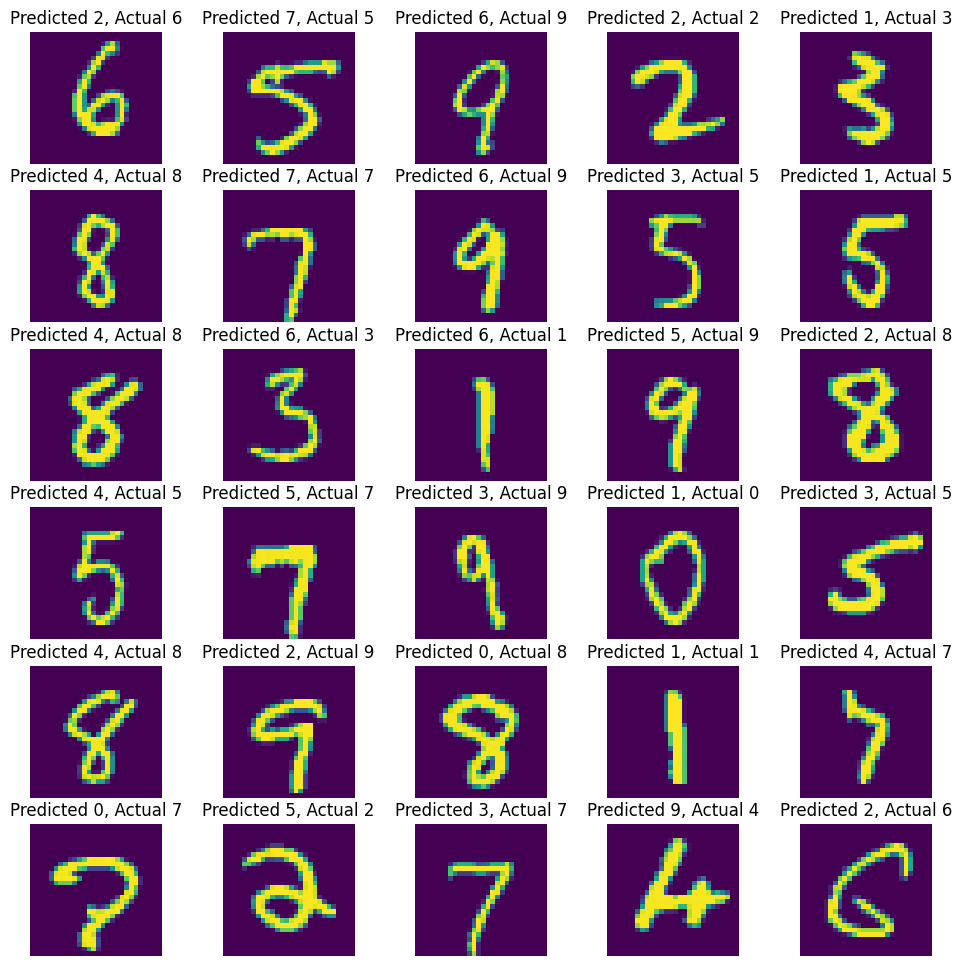

In [36]:
wrong_pred(model2,test_loader,test_data,30,6,5)

In [37]:
from torchviz import make_dot

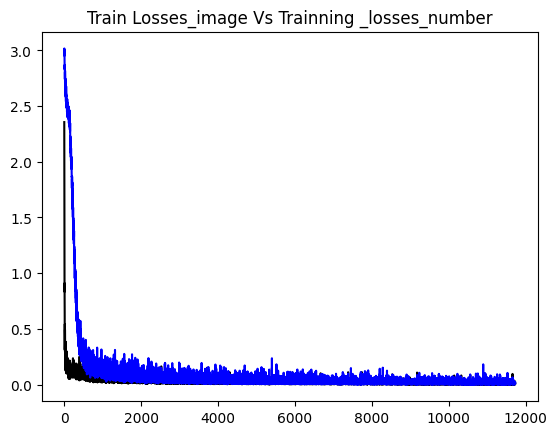

In [38]:
_ = plt.plot(train_losses_image,color = 'black')
_ = plt.plot(train_losses_random,color = 'blue')
# _ = plt.title('Train Losses_image Vs Trainning _losses_number')
_ = plt.title('Train Losses_image Vs Trainning _losses_number')

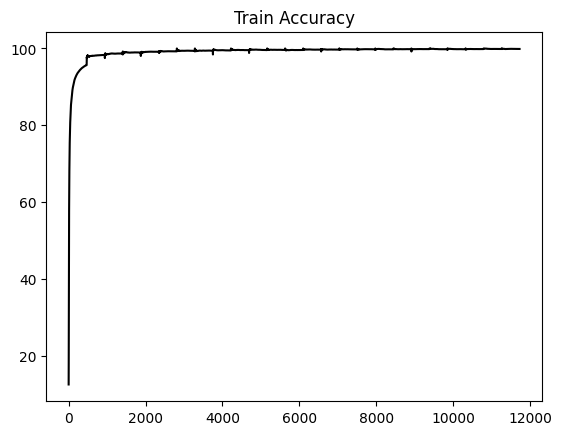

In [39]:
_ = plt.plot(train_acc,color = 'black')
_ = plt.title('Train Accuracy')

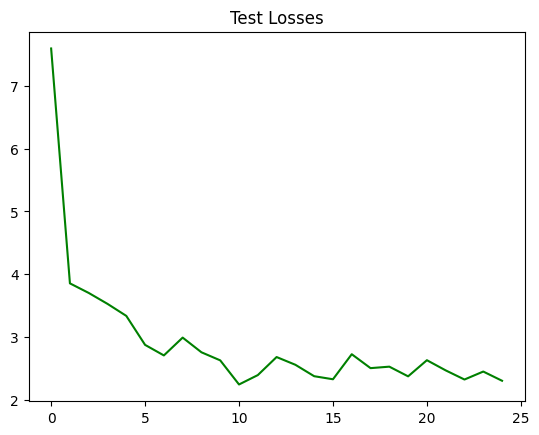

In [40]:
_ = plt.plot(test_losses_image,color = 'green')
_ = plt.title('Test Losses')

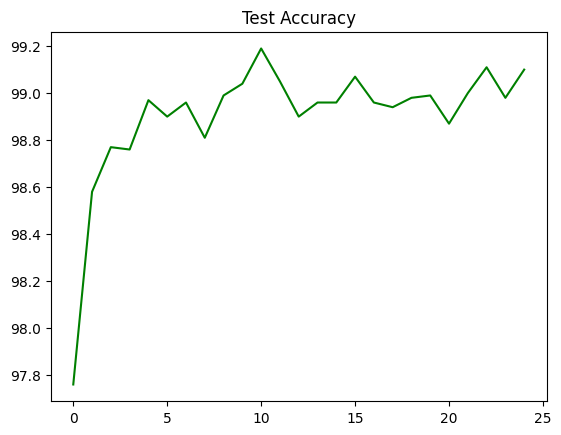

In [41]:
_ = plt.plot(test_acc,color = 'green')
_ = plt.title('Test Accuracy')

In [42]:
import random

In [43]:
def convert_image_np(inp,mean,std):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
    
def print_wrong_image(model,label,data_loader,mean,std,l,b):

    if l*b >= 30:
        n_images = 50
    
    labels = label
    wrong_images = []
    wrong_labels = []
    right_labels = []
    val = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for data,label,data1,label1 in data_loader:
        data, label = data.to(device), label.to(device)
        data1, label1 = data1.to(device), label1.to(device)
            
        # _=plt.imshow(np.transpose(data[16].to("cpu"),(1,2,0)))
        # _=plt.xlabel(f"Act:{labels[label[16].item()]} \n  ")
        with torch.no_grad():
            out,out1 = model(data,data1)
            wrong_idx = (out.to(device).argmax(dim = 1).eq(label.to(device)) ==False)
            val.extend(out[wrong_idx].to("cpu").max(axis = 1)[0])
            wrong_images.extend(data[wrong_idx].to("cpu"))
            wrong_labels.extend(out[wrong_idx].argmax(dim = 1).to("cpu"))
            right_labels.extend(label[wrong_idx].to("cpu"))

    wrong_idx = [i for i in range(0,len(wrong_images))]
    idx = [i for i in range(0,len(wrong_labels))]
    np.random.shuffle(wrong_idx)
    fig = plt.figure(figsize=(2.5*b,5*l))
    count = 1
    for image_index in wrong_idx:
        n= image_index
        ax = fig.add_subplot(l,b,count)
        # plt.imshow(np.array(np.transpose(data[10].to("cpu"),(1,2,0))))
        img_x = convert_image_np(wrong_images[image_index],mean,std)
        _=plt.imshow(img_x)
        # _=plt.title(f"wrong Images")
        _=plt.xlabel(f"Act:{labels[right_labels[image_index].item()]} \n Pred: {labels[wrong_labels[image_index].item()]} \n Val: {val[image_index].item()}")
        
        fig.tight_layout(pad = 0.5)
        count+= 1
        if count== (l*b)+1:
            break
    _ = plt.autoscale()
    _= plt.show()
    return wrong_images,wrong_labels,

In [63]:
for data,label,data1,label1 in train_loader:
    data, label = data.to(device), label.to(device)
    data1, label1 = data1.to(device), label1.to(device)
    break
    # _=plt.imshow(np.transpose(data[16].to("cpu"),(1,2,0)))
    # _=plt.xlabel(f"Act:{labels[label[16].item()]} \n  ")
    with torch.no_grad():
        out,out1 = model(data,data1)

In [64]:
data.shape

torch.Size([128, 1, 28, 28])

In [65]:
data1.shape

torch.Size([128, 10])

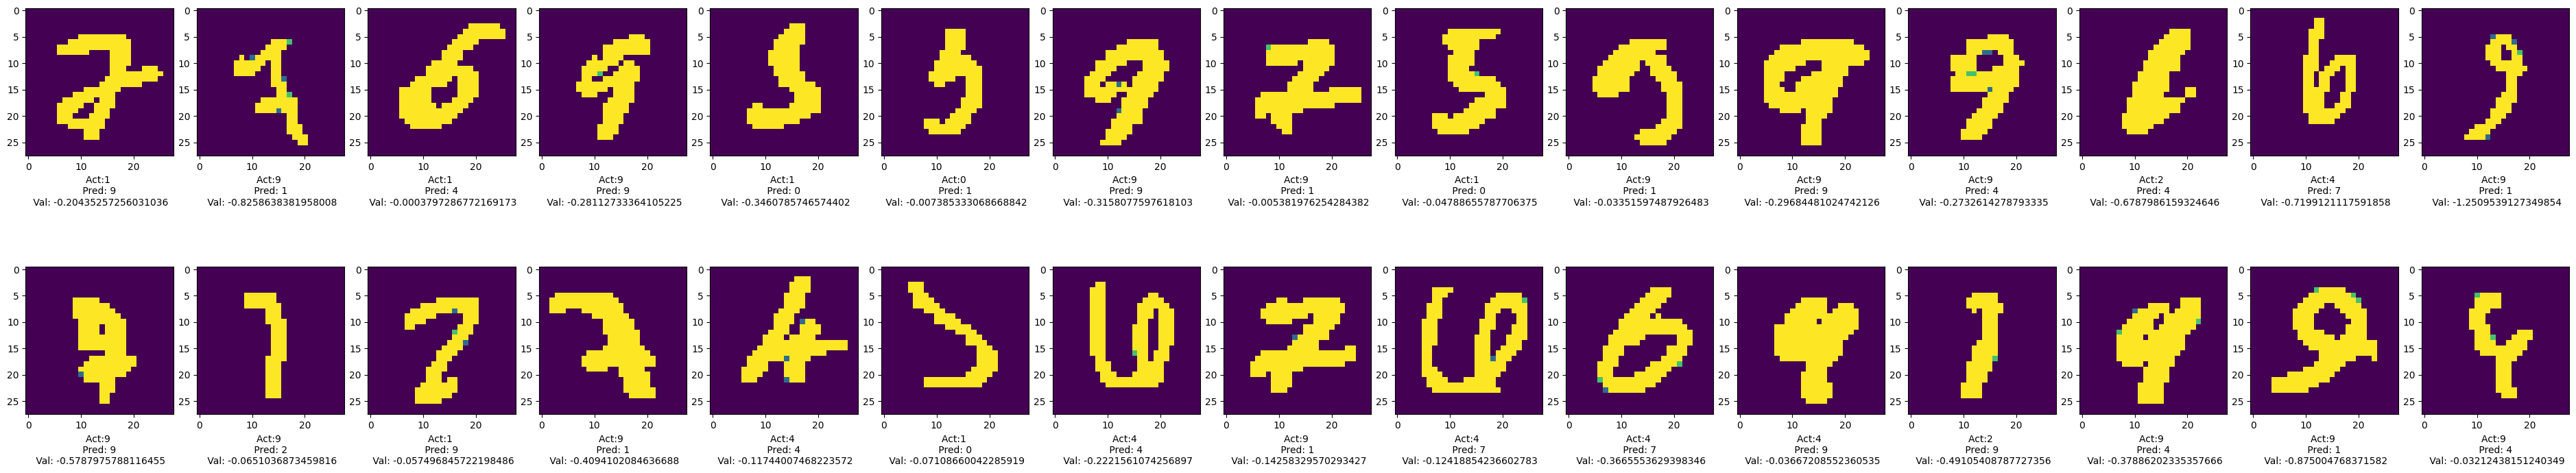

In [44]:
_= print_wrong_image(model2,test_loader.dataset.image_labels,test_loader,0.1307,0.3081,2,15)

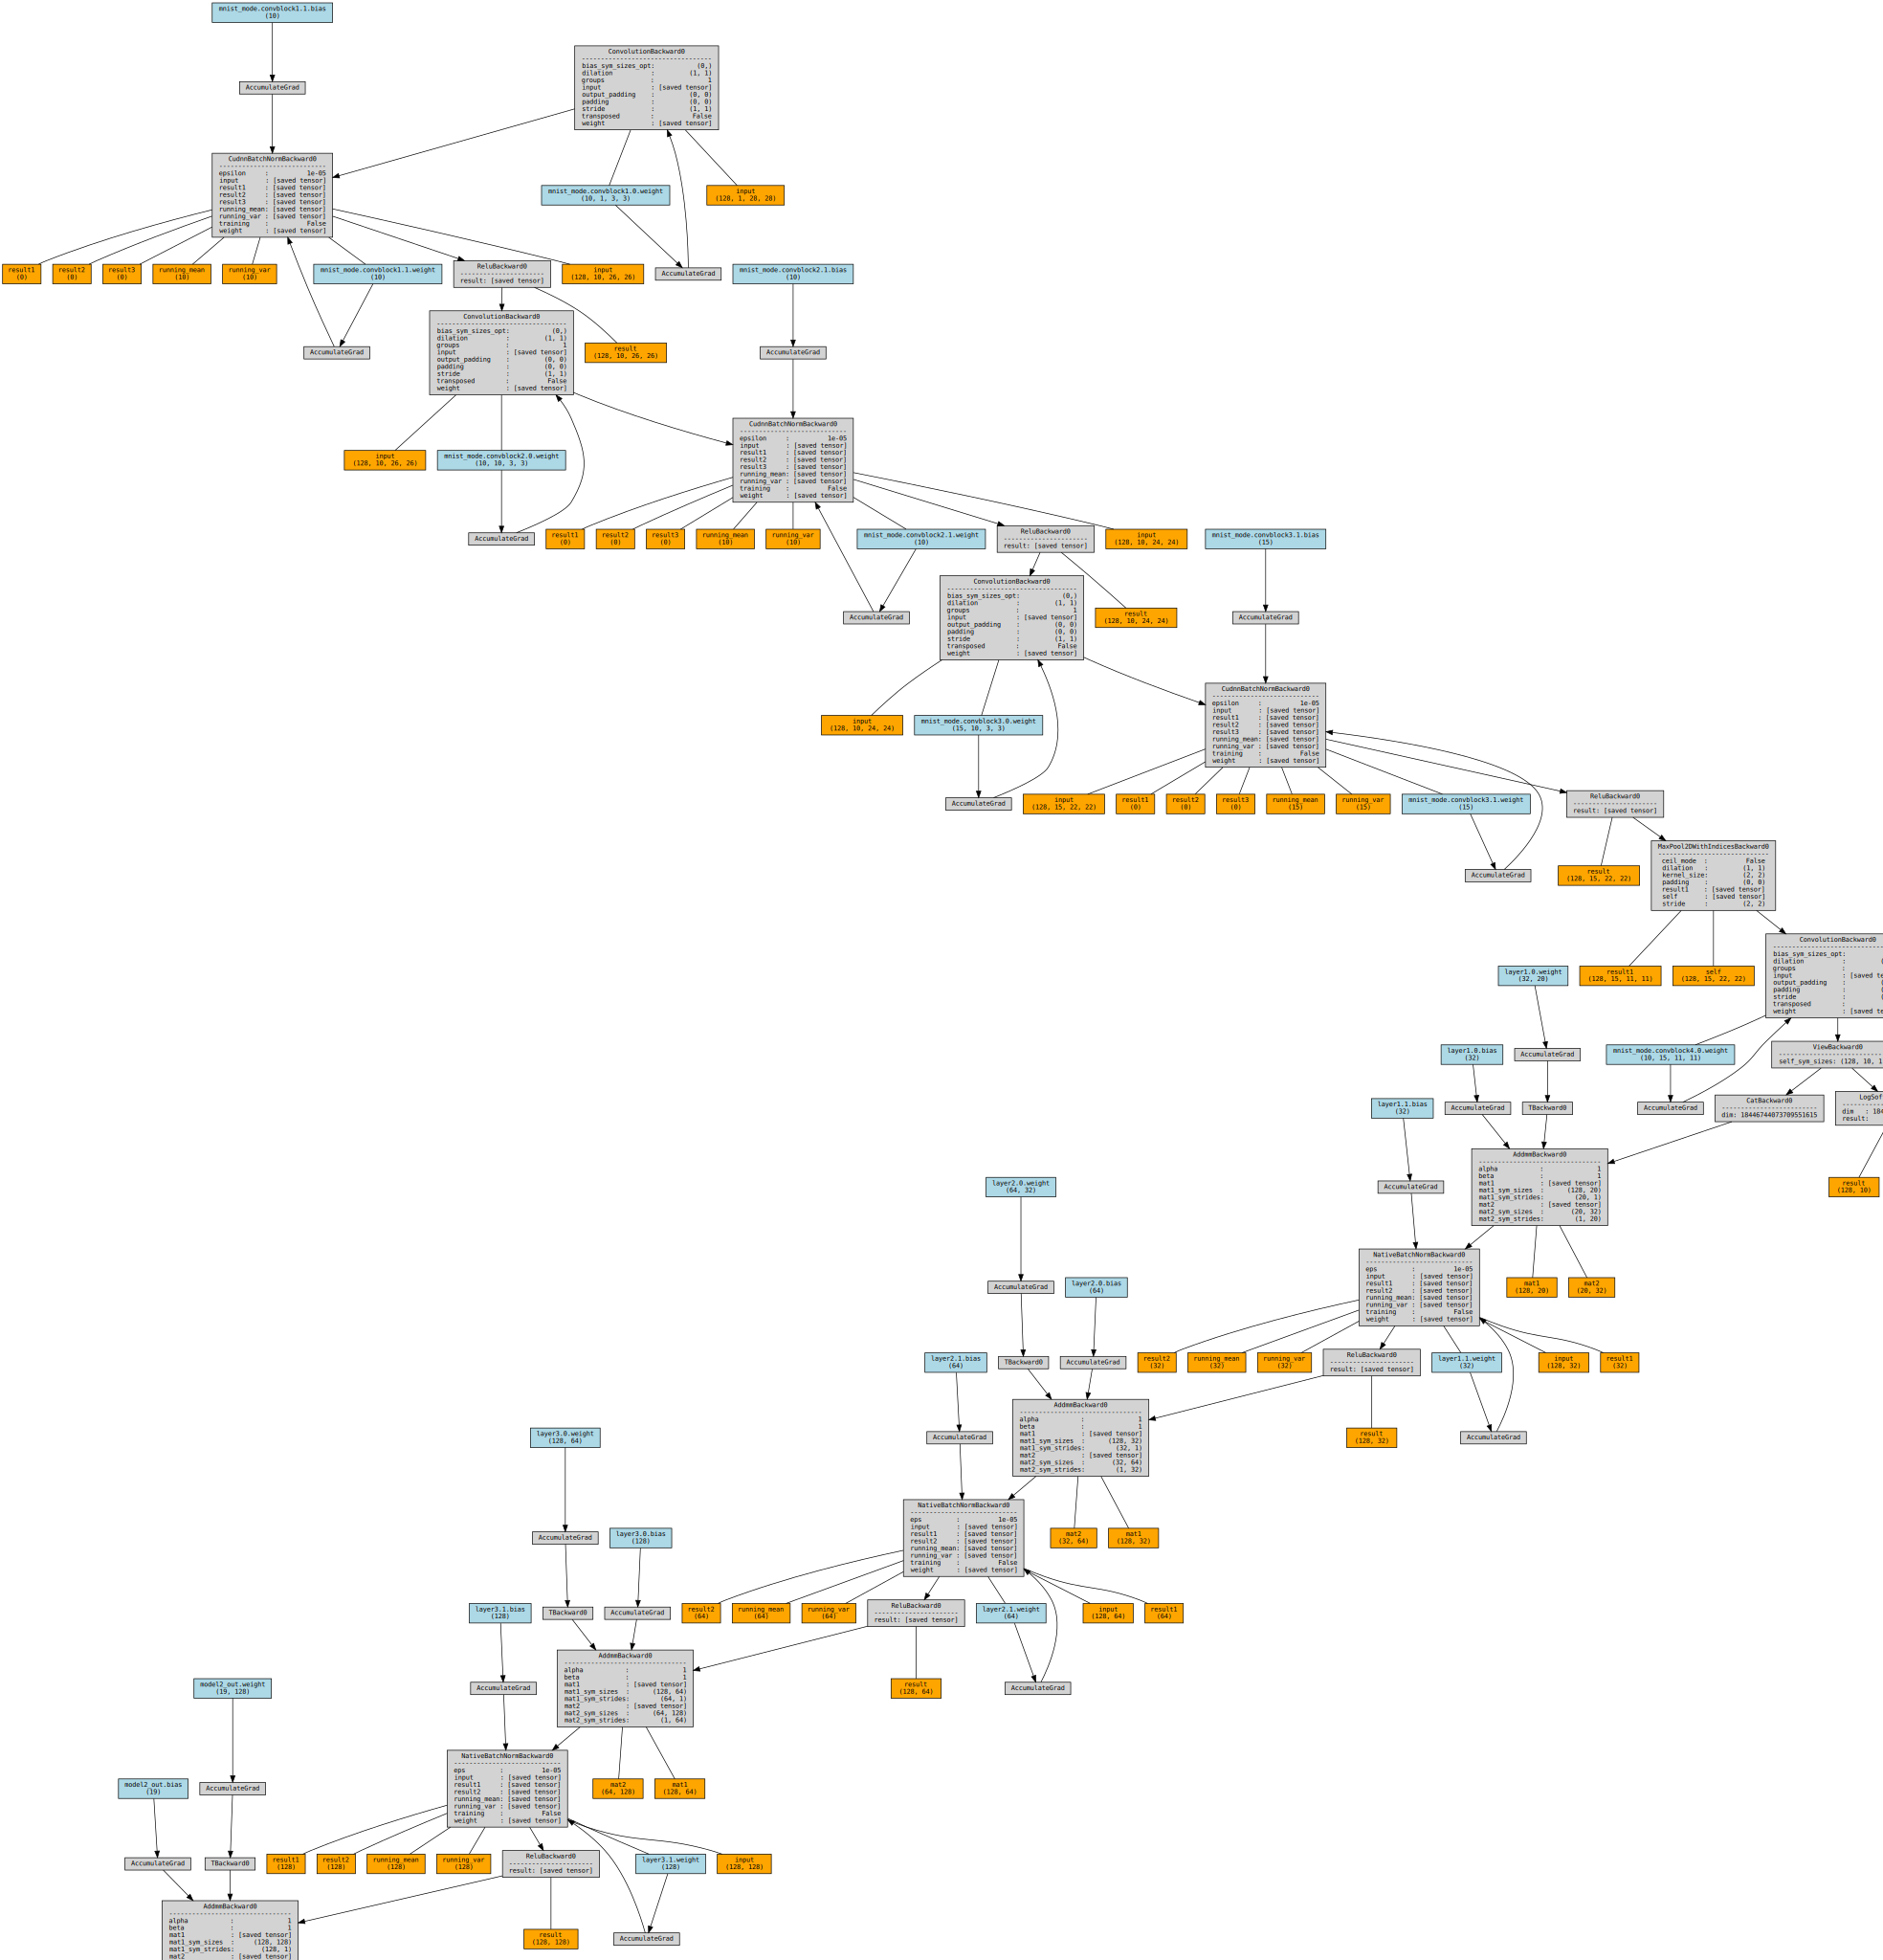

In [45]:
from torchviz import make_dot
for data1,target1,data2,target2 in test_loader:
    break
a,b = model2(data1.to(device),data2.to(device))
model_image = make_dot(var=(a.mean(),b.mean()),params=dict(model2.named_parameters()), show_attrs=True, show_saved=True)
model_image

In [46]:
gpu_check()
!nvidia-smi

The Seed is set to 1
Model will Run on CUDA.


(True, 1, 'cuda')

Thu Dec 29 20:59:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P5    22W /  N/A |   1757MiB / 16384MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
clean_gpu()